# Exercise: Predicting Human Transcription start sites

In this exercise we will work with a set of **human promoter sequences** and try to predict whether a location is a **Transcription Start Site (TSS)**. 

A TSS is the location where the first DNA nucleotide is transcribed into RNA, while a [promoter](https://www.genome.gov/genetics-glossary/Promoter) is a region of DNA upstream of a gene where proteins involved in the transcription process bind so that the gene's transcription can begin.

In order to perform our predictive tark, we will take advantage of a neural network.

In detail, the neural network will take a "window" around a position in the DNA and predict whether the position is a transcription start site or not. Since the network will answer a yes/no question about the position, our task is a binary classification task.

Therefore, we will also learn how to encode a DNA sequence to give in input to a neural network. Furthermore, we will see how convolution can be applied to this classification problem.

## Questions

Throughout this exercise we will answer a series of questions:

### #1 Is the network over-fitting?

First, we want to see whether the network we build is over-fitting. Indeed, an over-fitting network fits very well the training data but generalizes very poorly on sets of new data points (namely points that the network has not seen during training) and is, therefore, an undesirable model.

### #2 Which network performs best between a fully connected network and a convolutional network?

Since we are trying to solve our prediction problem by testing out both a fully connected network and a convolutional network, we want to see which one performs best.

### #3 Does the convolutional network improve when tweaking its architecture/parameters properly?

We will analyze the impact of various changes to the convolutional network to assess whether any of them improves the network's performances.

In detail, we will modify:

* The size of the input
* The network's parameters
* The number of hidden units
* The number of hidden layers

### #4 What do you think about the network's performance?

In your opinion, is the network's performance impressive/good/poor?

## Let's get started!

### #1 Download the data

We will work with data consists of human sequences from the EPD database. You can find the data inside the same folder of the notebook.

We select the sequences containing 999 bases before the TSS and 1000 bases after, and use the FASTA file containing them. In a FASTA file, each sequence (= a string of letters representing the nucleotides in the sequence) is preceeded by a line starting with a greater-than sign (`>`) that contains information about the sequence.

These sequences will be our "positive" examples. We will use random positions in the same sequences as "negative" examples.

In [7]:
# Path to the FASTA file
fasta_file = "EPD_all_hg38.fa"

### #2 Install ``biopython``

In [3]:
# We use the pip package manager to install biopython
!pip -q install biopython

### #3 Prepare the data for the neural network

#### Create a class to represent the datasets

In [55]:
# Import random because we need random number
# generation
import random
# Import re to deal with regular expressions
import re
# Import sys to print out error/log messages
import sys
# Import the sequence I/O module from Biopython
from Bio import SeqIO
# Import dataset utilities from PyTorch
from torch.utils.data import Dataset, DataLoader


class DNADataset(Dataset):
  
    """
    This class is used to build the data set of promoter
    sequences.
    """
  
    def __init__(self,
                 fasta_file,
                 win_before,
                 win_after,
                 pos = 1000,
                 n_neg = 1):
        """
        Initialize the dataset.

        To build it, you need to specify:

        * A FASTA file where the sequences are stored.
        * The length of the window before the TSS.
        * The length of the window after the TSS.
        * The position of the TSS.
        * How many negative examples to randomly draw for
          each positive example.
        """

        # The TSS is at pos 'pos', so we extract the beginning
        # of the window calculating the difference between
        # 'pos' and 'win_before'
        tss = pos - win_before
        
        # The total window length is going to be the sum of the
        # window length before the TSS and of the window length
        # after the TSS, plus 1 since the TSS is 1 base long 
        win_len = win_before + win_after + 1

        # Initialize empty lists for inputs and targets
        self.inputs = []
        self.targets = []

        # For each sequence in the FASTA file
        for seq_record in SeqIO.parse(fasta_file, "fasta"):

            # Get the last position where you can start
            # the window
            max_pos = len(seq_record.seq) - win_len - 1

            # For each negative example we want to pick
            # from the sequence
            for i in range(n_neg + 1):
                
                # Set 'k' equal to the TSS
                k = tss
                
                # If you are at the first negative example
                if i == 0:
                    
                    # Create a tensor containing 1.0
                    target = torch.tensor(1.)
                
                # Otherwise
                else:
                    
                    # Pick a random position as negative example
                    target = torch.tensor(0.)
                    
                    # While 'k' is equal to the TSS
                    while k == tss:
                        
                        # Update 'k' so that it is a random
                        # integer between 0 and the last position
                        # where you can start the window 
                        k = random.randint(0, max_pos)

                # Get the substring from 'k' to 'k' + 'win_len' and
                # make it all uppercase
                s = str(seq_record.seq[k:k+win_len]).upper()

                # If the substring contains only ACGT symbols
                if re.match("[^ACGT]", s) is None:

                    # Convert to a one-hot encoding and append
                    # the example to the lists
                    self.inputs.append(one_hot_dna(s))
                    self.targets.append(target)

                # Otherwise
                else:

                    # Inform the user that the sequence will be ignored
                    warnstr = \
                        f"The sequence '{s}' contains non-ACGT " \
                        f"symbols. Therefore, it will be ignored."
                    sys.stdout.write(warnstr)   
            
    # The __getitem__ method must be implemented for subclasses
    # of torch.utils.data.Dataset. This method is used to return
    # a specific element of the dataset, given its index.
    def __getitem__(self,
                    index):
        
        return self.inputs[index], self.targets[index]
    
    # The __len__ method returns the length of the dataset
    def __len__(self):
        
        return len(self.targets)

#### Define helper functions, if any

In [56]:
def one_hot_dna(seq):
    """Take a string (or a BioPython sequence like "dna.seq") and
    convert it to a 2D tensor representing a one-hot encoding of
    the string. The tensor has dimensions [4, sequence_lenght] and
    any given character N is encoded as 0,0,0,0.
    """
    # Create the dictionary from which the encoding of each letter
    # will be taken
    hot_dna = \
        {"A":(1.,0.,0.,0.), "T":(0.,0.,0.,1.),
         "C":(0.,1.,0.,0.), "G":(0.,0.,1.,0.),
         "N":(0.,0.,0.,0.)}
    
    # Return the one-hot encoding for the given sequence
    return torch.tensor([hot_dna[c] for c in seq])

#### Set some options for the training and validation datasets and for using the GPU, if available

In [57]:
# Import PyTorch
import torch

#------------------------------ Window -------------------------------#

# Set the size of the window before the TSS
win_before = 100

# Set the size of the window after the TSS
win_after = 20

# Calculate the total window size (add one to the sum
# of the before/after windows because the TSS is 1 base
# long)
win_len = win_before+win_after+1

#------------------------- Negative examples -------------------------#

# Total number of promoter examples is around 29000.
# For each positive example, we generate n_neg netagive examples from
# random places in the sequences.
# Total number of examples is, therefore, about 29000*(1+n_neg)
n_neg = 1

#--------------------- Training/validation sets ----------------------#

# Fraction of the data that will be used as training set
# (the smaller the fraction, the faster the learning)
train_fraction = 0.5

# Fraction of the data that will be used as validation set
validation_fraction = 0.05

# Another example could be:
#train_fraction = 0.8
#validation_fraction = 1 - train_fraction

# The size of the mini-batches used during training
batch_size = 256

#---------------------------- GPU options ----------------------------#

# Check whether a GPU is available
use_cuda = torch.cuda.is_available()

# Use the GPU if available; otherwise, use the CPU
device = torch.device("cuda:0" if use_cuda else "cpu")

#### Create the training and validation datasets

In [58]:
# Create a DNADataset with the sequences of interest
# and the specified options
all_data = DNADataset(fasta_file = fasta_file,
                      win_before = win_before,
                      win_after = win_after,
                      n_neg = n_neg)


# Get the total number of examples
n_tot = len(all_data)

# Get the indices (drawn at random) for the examples that will
# go into the training and validation datasets
indices = torch.randperm(n_tot)

#------------------------- Tranining dataset -------------------------#

# Get the number of examples that should be included in the
# training dataset
n_train = int(train_fraction * n_tot)

# Get the subset of the total data that will constitute the
# training dataset
train_subset = \
    torch.utils.data.Subset(all_data,
                            indices[:n_train])

# Create a DataLoader object for the training dataset to automate
# the use of minibatches
train_loader = \
    torch.utils.data.DataLoader(train_subset,
                                batch_size = batch_size)

#------------------------ Validation dataset -------------------------#

# Get the number of examples that should be included in the
# validation dataset
n_validation = int(validation_fraction * n_tot)

# Get the subset of the total data that will constitute the
# validation dataset
validation_subset = \
    torch.utils.data.Subset(all_data,
                            indices[n_train:n_train+n_validation])

# Create a DataLoader object for the validation dataset to automate
# the use of minibatches
validation_loader = \
    torch.utils.data.DataLoader(validation_subset,
                                batch_size = batch_size)

# Sometimes it is convenient to work with all test data as one
# large tensor
validation_data = \
    torch.cat([validation_subset[i][0].unsqueeze(0) \
               for i in range(n_validation)]).to(device)
validation_target = \
    torch.cat([validation_subset[i][1].unsqueeze(0) \
               for i in range(n_validation)]).flatten()
print(n_tot)

59196


### #4 Initialize the parameters for the neural network

In [59]:
#---------------------- Fully connected network ----------------------#

# Set the number of neurons in the first hidden layer
n_hidden1 = 10

# Set the number of neurons in the second hidden layer
n_hidden2 = 5

#----------------------- Convolutional network -----------------------#

# The convolutional network will have a convolution layer and one
# hidden layer with 'n_hidden1' hidden units

# Set the number of channels
n_channels = 10

# Set the kernel size
kernel_size = 4

#------------------------ Training procedure -------------------------#

# Number of epochs
n_epochs = 50

# Weight decay
weight_decay = 1.e-5

### #5 Define the convolutional neural network 

In [60]:
# Import the neural network module from PyTorch
import torch.nn as nn
# Import the functional module from PyTorch
import torch.nn.functional as F

class ConvolutionNet(nn.Module):
    
    """
    Class definining a convolutional neural network.
    """
    
    def __init__(self,
                 win_len,
                 n_hidden,
                 n_channels,
                 kernel_size):
        
        # Initialize the network as its parent class
        super(ConvolutionNet, self).__init__()
        
        # Set the number of output units from the convolution
        self.n_conv_out = n_channels * (win_len - kernel_size+1)
        
        # It is a 2D kernel, because the input is (win_len, 4).
        # Alternatively, one could use a 1D tensor of size
        # 4 * win_len and a 1D convolution with stride 4.
        # The 'kernel_size' is the number of nucleotides in
        # the convolution.
        self.conv1 = \
            nn.Conv2d(in_channels = 1,
                      out_channels = n_channels,
                      kernel_size = (kernel_size, 4),
                      stride = 1,
                      padding = 0)
        
        # Set a fully connected layer after the convolution layer
        self.fc1 = \
            nn.Linear(in_features = self.n_conv_out,
                      out_features = n_hidden)
        
        # Set the final linear output layer
        self.fc2 = \
            nn.Linear(in_features = n_hidden,
                      out_features = 1)
     
    def forward(self,
                x):
        """Forward pass.
        """
        
        # The ReLU activation function is used on the hidden
        # layers
        x = F.relu(self.conv1(x.unsqueeze(1))).view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### #6 Select the network to use

In [61]:
# Change to True if you want to use the convolutional network
# instead
convolution = False

# If 'convolution' is True
if convolution:
    
    # The class defined above is used
    model = \
        ConvolutionNet(win_len = win_len,
                       n_hidden = n_hidden1,
                       n_channels = n_channels,
                       kernel_size = kernel_size).to(device)

# Otherwise
else:
    
    # A standard feed-forward fully connected network is used.
    # (Flatten() is needed to make the input tensor 1-dimensional.
    model = \
        torch.nn.Sequential(torch.nn.Flatten(),   
                            torch.nn.Linear(win_len * 4, n_hidden1),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden1, n_hidden2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden2, 1)).to(device)

### #7 Train the network

In [62]:
# Set the optimizer. We use the Adam optimizer here.
optimizer = \
    torch.optim.Adam(model.parameters(),
                     weight_decay = weight_decay)

# Set the loss function. BCEWithLogitsLoss is used with
# linear outputs and corresponds to a sigmoid activation
# followed by a binary cross entropy loss.
loss_func = torch.nn.BCEWithLogitsLoss()

# Move target values to GPU
v_target = validation_target.to(device)

# Initialize a dictionary to store the performance
# values
performance = \
    {"Epoch" : [],
     "Train loss" : [],
     "Train wrong" : [],
     "Test loss" : [],
     "Test wrong": [],
    }

#------------------------------- Train -------------------------------#

# For each epoch
for epoch in range(n_epochs):
    
    # Save the epoch number and the train loss/train wrong
    # performances (initialized to 0)
    performance["Epoch"].append(epoch)
    performance["Train loss"].append(0)
    performance["Train wrong"].append(0)
    
    # For each minibatch of inputs (x) and associated targets (t)
    for x, t in train_loader:
        
        # Set the gradients to 0
        optimizer.zero_grad()
        
        # Move inputs and targets to the selected device
        x = x.to(device)
        t = t.to(device)
        
        # Pass the inputs through the network and flatten
        # the outputs
        y = model(x).flatten()
        
        # Calculate the loss between the network's outputs
        # and the target
        loss = loss_func(y, t)
        
        # Backpropagate the loss
        loss.backward()
        
        # Take an optimization step
        optimizer.step()
        
        # Disable gradient calculation
        with torch.no_grad():
            
            # Update the train loss
            performance["Train loss"][-1] += loss.item()*len(y) / n_train

            # Count the number of outputs that are correct
            # (threshold 0.5)
            y = torch.sigmoid(y)
            performance["Train wrong"][-1] += (2*t-1).mul(2*y-1.).lt(0.0).sum().item() / n_train
    
    # Disable gradient calculation
    with torch.no_grad():
        
        # Pass the validation data through the network
        # and flatten the outputs
        y = model(validation_data).flatten()
        
        # Save the test loss
        performance["Test loss"].append(loss_func(y, v_target).item())
        
        # Count the number of outputs that are wrong
        y = torch.sigmoid(y)
        # (target-0.5)*(y-0.5) < 0 if the prediction is wrong
        performance["Test wrong"].append((v_target-0.5).mul(y-0.5).lt(0.0).sum().item() / n_validation)
    
    # Print out the performances every 5 epochs
    if (epoch+1) % 5 == 0:
        
        infostr = \
            f"Epoch: {epoch+1}. " \
            f"Train wrong: {performance['Train wrong'][-1]}. " \
            f"Test wrong: {performance['Test wrong'][-1]}.\n"
        
        sys.stdout.write(infostr)


Epoch: 5. Train wrong: 0.20629772281910946. Test wrong: 0.213247718823927.
Epoch: 10. Train wrong: 0.19656733563078582. Test wrong: 0.2169651909428861.
Epoch: 15. Train wrong: 0.19197243056963306. Test wrong: 0.22135856708347415.
Epoch: 20. Train wrong: 0.1838299885127373. Test wrong: 0.20885434268333897.
Epoch: 25. Train wrong: 0.17683627272112984. Test wrong: 0.20750253464008112.
Epoch: 30. Train wrong: 0.1730860193256301. Test wrong: 0.19939168638053398.
Epoch: 35. Train wrong: 0.17014663152915738. Test wrong: 0.1953362622507604.
Epoch: 40. Train wrong: 0.1681194675315899. Test wrong: 0.19466035822913147.
Epoch: 45. Train wrong: 0.16663288060004053. Test wrong: 0.19161879013180128.
Epoch: 50. Train wrong: 0.16528143793499553. Test wrong: 0.1922946941534302.


### #8 Plot the loss

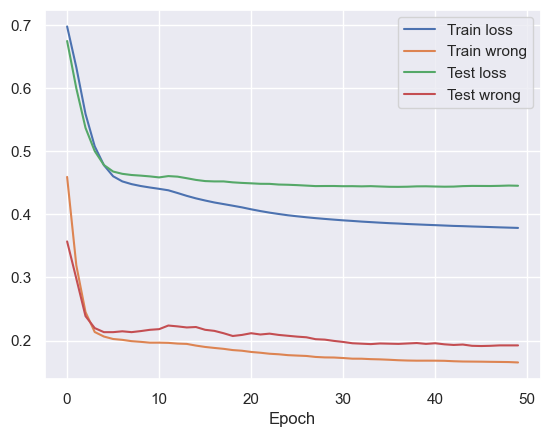

In [63]:
# Import matplotlib and seaborn for plotting
# purposes
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Import pandas to manipulate the data
import pandas as pd

# Set the seaborn theme
sns.set()

# Create a data frame from the dictionary where the
# performances were saved
df = pd.DataFrame.from_dict(performance).set_index("Epoch")

# Generate and show a line plot with the loss
sns.lineplot(data = df,
             dashes=False)
plt.show()

### #9 Plot the ROC curve

In [16]:
import numpy

def ROCandRoll(target,
               output):
    """Take in input a tensor of target values (must be 0/1)
    and prediction outputs and return a dictionary with the
    false positives (FP) rate, the true positives (TP) rate,
    the sorted outputs and the sorted targets.
    """
      
    # Disable gradient calculation
    with torch.no_grad():
        
        # Get the length of the data passed from the
        # length of the targets
        n = len(target)
        
        # Get the number of positive examples
        n_pos = target.sum()
        
        # Get the number of negative examples
        n_neg = n - n_pos
        
        # Sort the outputs
        z, order = torch.sort(output)
        
        # Sort the targets the same way
        target = target[order]
        
        # Get the true positives (TP). The cumulative counts
        # of targets = 1 are the false negatives (FN) counts.
        TP = n_pos - torch.cumsum(target, dim = 0)
        
        # Get the false positives (FP)
        FP = torch.arange(n, 0, step = -1) - TP
        
        # Save the rates and sorted outputs/targets
        roc = \
            {"TP rate" : (TP / n_pos).numpy(),
             "FP rate" : (FP / n_neg).numpy(),
             "Sorted outputs": z.numpy(),
             "Sorted targets" : target.numpy(),
            }
        
        # Calculate and save the AUC
        roc["AUC"] = \
            sum([0.5*(roc["TP rate"][i] + \
                      roc["TP rate"][i+1]) * \
                (roc["FP rate"][i] - roc["FP rate"][i+1]) \
                 for i in range(n - 1)])
        
        # Return the dictionary
        return roc


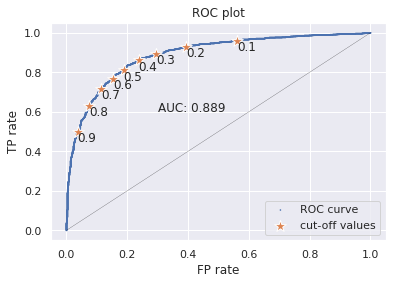

In [12]:
# ROC curve
with torch.no_grad():
  # Get the outputs for all validation data
  y = torch.sigmoid(model(validation_data).flatten()).cpu()
  roc = ROCandRoll(validation_target, y)

# Set the Seaborn theme
sns.set()

# Generate a scatter plot because the line plot is
# very slow
sns.scatterplot(data = roc, 
                x = "FP rate",
                y = "TP rate",
                # Type of marker
                marker = ".",
                # Size of the markers
                s = 10,
                # Set the border color for the markers
                edgecolor = "none",
                # Set the legend label for the markers
                label = "ROC curve").set_title("ROC plot")

# Plot the AUC
plt.plot([0., 1.], [0., 1.], 
         # Width of the line
         linewidth = 0.2,
         # Color of the line
         color = 'black')

# Add the text with the AUC value
plt.text(0.3, 0.6, 
         "AUC: " + "%0.3f" % roc["AUC"],
         horizontalalignment = "left")

# Decorate the ROC curve with the threshold values
cut = 0.1

points = [[],[]]

for i in range(n_validation):
    if roc["Sorted outputs"][i] > cut:
        points[0].append(roc["FP rate"][i])
        points[1].append(roc["TP rate"][i])
        plt.text(roc["FP rate"][i], 
                 roc["TP rate"][i], 
                 "%0.1f" % cut,
                 horizontalalignment = "left",
                 verticalalignment = "top")
        cut += 0.1

sns.scatterplot(x = points[0],
                y = points[1],
                # Use a different type of marker
                marker = "*",
                # Make the markers bigger
                s = 150,
                alpha = 1,
                label = "cut-off values")

# Show the complete plot
plt.show()